# Lab2: AutoML for Classification

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

We are going to use the AutoML feature of Azure ML. 
Automated machine learning, also referred to as **automated ML or AutoML**, is the process of automating the time consuming, iterative tasks of machine learning model development. It allows data scientists, analysts, and developers to **build ML models with high scale, efficiency, and productivity all while sustaining model quality**. Automated ML is based on a breakthrough from our **Microsoft Research division**.

Traditional machine learning model development is resource-intensive, requiring significant domain knowledge and time to produce and compare dozens of models. With automated machine learning, **you'll accelerate the time it takes to get production-ready ML models with great ease and efficiency**.

<img src="https://docs.microsoft.com/ko-kr/azure/machine-learning/service/media/how-to-automated-ml/automl-concept-diagram2.png">

This is a copy of the test set of the **UCI ML hand-written digits datasets** http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where each class refers to a digit.



<img src="https://www.seewald.at/img/L/digits.gif">


### Azure AutoML documentation
> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## 1. Informations

As part of the setup you have already created an Azure ML `Workspace` object. <br> For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2020-12-14 14:01:00.251777


In [3]:
import azureml.core
print("Azure ML version is", azureml.core.VERSION)

Azure ML version is 1.18.0


In [4]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

## 2. Experiment

In [5]:
ws = Workspace.from_config()

experiment_name = 'Lab2-AutoML'

project_folder = './sample_projects/lab2'

experiment = Experiment(ws, experiment_name)

output = {}
output['Azure ML SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
Azure ML SDK version,1.18.0
Workspace Name,AMLworkshop
Resource Group,AMLworkshop-rg
Location,westeurope
Project Directory,./sample_projects/lab2
Experiment Name,Lab2-AutoML


## 3. Loading the dataset

This uses scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.
Each datapoint is a 8x8 image of a digit.

In [6]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

In [7]:
print("Dataset Size =", digits.data.shape)

Dataset Size = (1797, 64)


In [8]:
def view(number):
    import matplotlib.pyplot as plt 
    plt.gray() 
    plt.matshow(digits.images[number]) 
    plt.show() 

<Figure size 432x288 with 0 Axes>

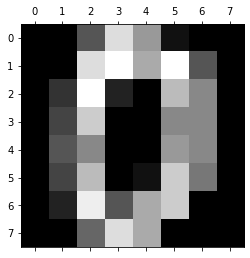

In [9]:
view(0)

<Figure size 432x288 with 0 Axes>

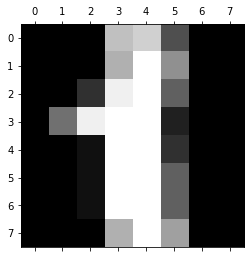

In [10]:
view(1)

<Figure size 432x288 with 0 Axes>

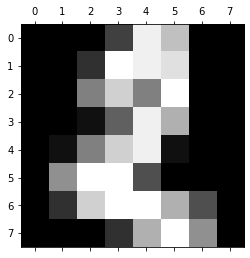

In [11]:
view(2)

<Figure size 432x288 with 0 Axes>

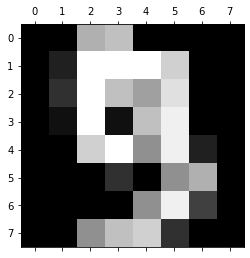

In [12]:
view(9)

<Figure size 432x288 with 0 Axes>

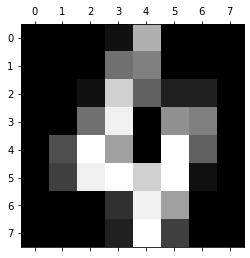

In [13]:
view(4)

## 4. AutoML configuration



In [14]:
automl_config = AutoMLConfig(task = 'classification', #AutoML is also available for Regression and Time series forecasting
                             debug_log = 'automlclassif.log',
                             primary_metric = 'AUC_weighted', #the metric I want to use to sort the models
                             iteration_timeout_minutes = 2, #Timeout for each iteration
                             experiment_timeout_minutes = 15, #timeout for the whole process
                             enable_early_stopping=True, 
                             iterations = 10,           # number of max iterations
                             n_cross_validations = 3,    # Cross validation
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train)

WARNING - The AutoMLConfig parameters, X and y, will soon be deprecated. Please refer to our documentation for the latest interface: https://aka.ms/AutoMLConfig


## 5. AutoML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

`AUC_weighted` is the **metric** used.

In [15]:
#Only if you want to upgrade
#!pip install --upgrade azureml-sdk[automl]
#!pip install --upgrade azureml-sdk[explain,contrib]
#!pip install interpret-community==0.14.3

## Let's run the AutoML process in a local machine (ie your compute instance)

> List of the available models: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train#supported-models

In [16]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_a8a7acd2-7ccb-4130-b678-bf7845354aa3

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing f

## 6. AutoML results

### 6.1 Go the experiment to view the results

In [17]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
Lab2-AutoML,AutoML_a8a7acd2-7ccb-4130-b678-bf7845354aa3,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


### 6.2 AutoML Widget for interactive results from the notebook

In [18]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### 6.3 Metrics for each iteration of the AutoML process

In [19]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
log_loss,0.11,0.13,0.83,1.07,0.66,0.94,0.56,1.12,0.24,0.17
precision_score_weighted,0.96,0.96,0.86,0.92,0.93,0.85,0.93,0.79,0.97,0.97
precision_score_micro,0.96,0.96,0.86,0.92,0.93,0.84,0.93,0.78,0.96,0.96
f1_score_micro,0.96,0.96,0.86,0.92,0.93,0.84,0.93,0.78,0.96,0.96
average_precision_score_micro,0.99,0.99,0.93,0.96,0.98,0.91,0.98,0.84,1.00,0.99
accuracy,0.96,0.96,0.86,0.92,0.93,0.84,0.93,0.78,0.96,0.96
recall_score_macro,0.96,0.96,0.86,0.92,0.93,0.84,0.93,0.78,0.96,0.97
recall_score_weighted,0.96,0.96,0.86,0.92,0.93,0.84,0.93,0.78,0.96,0.96
matthews_correlation,0.96,0.96,0.84,0.91,0.92,0.82,0.92,0.76,0.96,0.96
f1_score_weighted,0.96,0.96,0.86,0.92,0.93,0.84,0.93,0.75,0.96,0.96


## 7. We want to retrieve the best model

In [20]:
best_run, fitted_model = local_run.get_output()
print("Best AutoML run =", best_run)

Best AutoML run = Run(Experiment: Lab2-AutoML,
Id: AutoML_a8a7acd2-7ccb-4130-b678-bf7845354aa3_8,
Type: None,
Status: Completed)


In [21]:
print(fitted_model)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                  max_leaf_nodes=None,
                                                                                                  max_samples=None,
                                                                                                  min_impurity_decrease=0.0,
                                

In [22]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                  max_leaf_nodes=None,
                                                                                                  max_samples=None,
                                                                                                  min_impurity_decrease=

In [23]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                  feature_sweeping_config=None, feature_sweeping_timeout=None,
                  featurization_config=None, force_text_dnn=None,
                  is_cross_validation=None, is_onnx_compatible=None, logger=None,
                  observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                                estimators=[('0',
                                             Pipeline(memory=None,
                                                      steps=[('maxabsscaler',
                                                              MaxAbsScaler(copy=True)),
                                                             ('lightgbmclassifier',
                                                              LightGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                                                                 learning_rate=0.1,
                                                                                 max_depth=-1,
                                                                                 min_child_samples=20,
                                                                                 min_child_weight=0.001,
                                                                                 min_spl...
                                                                                   max_features='log2',
                                                                                   max_leaf_nodes=None,
                                                                                   max_samples=None,
                                                                                   min_impurity_decrease=0.0,
                                                                                   min_impurity_split=None,
                                                                                   min_samples_leaf=0.01,
                                                                                   min_samples_split=0.10368421052631578,
                                                                                   min_weight_fraction_leaf=0.0,
                                                                                   n_estimators=50,
                                                                                   n_jobs=1,
                                                                                   oob_score=False,
                                                                                   random_state=None,
                                                                                   verbose=0,
                                                                                   warm_start=False))],
                                                      verbose=False))],
                                flatten_transform=None,
                                weights=[0.6, 0.1, 0.1, 0.1, 0.1]))]

In [24]:
print("Metrics of the best model:")
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print('-', metric_name, '=', metric)

Metrics of the best model:

- log_loss = 0.24268999854197956
- precision_score_weighted = 0.9655422203157228
- precision_score_micro = 0.9640618322440768
- f1_score_micro = 0.9640618322440768
- average_precision_score_micro = 0.995034409614909
- accuracy = 0.9640618322440768
- recall_score_macro = 0.9644125659982171
- recall_score_weighted = 0.9640618322440768
- matthews_correlation = 0.9601512882417044
- f1_score_weighted = 0.9642126316369418
- balanced_accuracy = 0.9644125659982171
- norm_macro_recall = 0.9604584066646856
- weighted_accuracy = 0.9636466137285234
- f1_score_macro = 0.9643070187001982
- precision_score_macro = 0.9653605827539274
- recall_score_micro = 0.9640618322440768
- AUC_micro = 0.9992539478071206
- average_precision_score_weighted = 0.9952797406126982
- AUC_macro = 0.9992793963011941
- average_precision_score_macro = 0.9952762022235265
- AUC_weighted = 0.9992651620611631
- confusion_matrix = aml://artifactId/ExperimentRun/dcid.AutoML_a8a7acd2-7ccb-4130-b678-bf784

### 7.1 You can change the metric. Let's use now the F1 Score for example.

In [25]:
lookup_metric = "f1_score_weighted"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print("Best model :")
print()
print('Best Run =', best_run)
print()
print(fitted_model)

Best model :

Best Run = Run(Experiment: Lab2-AutoML,
Id: AutoML_a8a7acd2-7ccb-4130-b678-bf7845354aa3_9,
Type: None,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('stackensembleclassifier',
                 StackE...
                                         meta_learner=LogisticRegressionCV(Cs=10,
                                                                           class_weight=None,
                                                             

### We can take as well a specific iteration:

In [26]:
iteration = 3

my_run, my_model = local_run.get_output(iteration = iteration)
print("Model",iteration," iteration :")
print(my_run)
print()
print(my_model)

Model 3  iteration :
Run(Experiment: Lab2-AutoML,
Id: AutoML_a8a7acd2-7ccb-4130-b678-bf7845354aa3_3,
Type: None,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('RobustScaler',
                 RobustScaler(copy...
                                      class_weight=None, criterion='entropy',
                                      max_depth=None, max_features='log2',
                                      max_leaf_nodes=None, max_samples=None,
           

## 8. Testing the model

### 8.1 Loading some test images

In [27]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

### 8.2 Test
We will try to predict 2 digits and see how our model works.

4


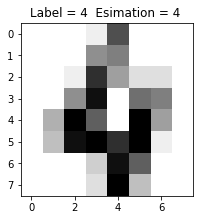

0


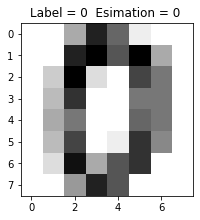

In [28]:
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label = %d  Esimation = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

## 9. Let's save the best model into the Azure ML models repository

In [29]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
print("Metrics:")
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, '=', metric)

Run(Experiment: Lab2-AutoML,
Id: AutoML_a8a7acd2-7ccb-4130-b678-bf7845354aa3_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                  max_leaf_nodes=None,
                                                                                                  max_samples=None,
                                             

In [30]:
for step in fitted_model.named_steps:
    print(step)

datatransformer
prefittedsoftvotingclassifier


In [31]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='mybestmodel',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 'Accuracy': best_run_metrics['accuracy']})

Model(workspace=Workspace.create(name='AMLworkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AMLworkshop-rg'), name=mybestmodel, id=mybestmodel:12, version=12, tags={'Training context': 'Azure Auto ML'}, properties={'AUC': '0.9992651620611631', 'Accuracy': '0.9640618322440768'})

> You can see the model in the **Model** section of Azure ML Studio

In [32]:
experiment

Name,Workspace,Report Page,Docs Page
Lab2-AutoML,AMLworkshop,Link to Azure Machine Learning studio,Link to Documentation


### We can have a list of all the models:

In [33]:
# List of all the models from the Azure ML workspace
for model in Model.list(ws):
    print(model.name, '- version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

mybestmodel - version = 12
	 Training context : Azure Auto ML
	 AUC : 0.9992651620611631
	 Accuracy : 0.9640618322440768


mnist-prs - version = 5
	 pretrained : mnist


sklearn_mnist - version = 18
	 data : Mnist
	 model : Classification
	 source : PKL file


IBM_attrition_explainer - version = 13


local_deploy_model - version = 13


DiabetesRidge - version = 20
	 area : Diabetes
	 type : Ridge
	 k : 0.2
	 MSE : 3026.6677
	 R2 : 0.4067
	 RMSE : 55.0152
	 Framework : Azure ML SDK


TensorFlow - version = 12
	 Framework : TensorFlow
	 Hyperdrive : Yes
	 GPU : Yes


mybestmodel - version = 11
	 Training context : Azure Auto ML
	 AUC : 0.9992595123176834
	 Accuracy : 0.9652386461948987


mnist-prs - version = 4
	 pretrained : mnist


sklearn_mnist - version = 17
	 data : Mnist
	 model : Classification
	 source : PKL file


DiabetesRidge - version = 19
	 area : Diabetes
	 type : Ridge
	 k : 0.2
	 MSE : 3026.6677
	 R2 : 0.4067
	 RMSE : 55.0152
	 Framework : Azure ML SDK


IBM_attrition_exp

> You can open now the **Lab3 notebook**.

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">